## PART A: 2,3 - RMSProp and Adam

This notebook was primarily used for creating and testing of variations of Gradient Descent Learning Rule - RMSProp[1] and Adam[2].

As noted in previous experiments, large number of deep layers results in large disturbances in convergence.


[1] T. Tieleman and G. E. Hinton. Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent
magnitude. COURSERA: Neural Networks for Machine Learning, 4(2), 2012. URL https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf.

[2] Diederik P. Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In ICML, 2015. URL
https://arxiv.org/abs/1412.6980.


### Setup

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

In [2]:
from mlp.learning_rules import *
%aimport mlp.errors
%aimport mlp.learning_rules

In [3]:
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 10102016
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

['inputs', 'targets']
['inputs', 'targets']
['inputs', 'targets']


In [4]:
from mlp.layers import AffineLayer, SoftmaxLayer, ELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.optimisers import Optimiser

#setup hyperparameters
learning_rate = 0.1
num_epochs = 50 # TODO: CHANGED HERE FOR TESTING ONLY!
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

In [5]:
# Create a single function to test a simple MLP with RELULayer:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(model,
                               error,
                               learning_rule,
                               train_data,
                               valid_data,
                               test_data,
                               num_epochs,
                               stats_interval,
                               notebook=True):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        data_monitors,
        notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys[k]],
            label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys[k]],
            label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

### Baseline

Run an experiment using SGD learning rule for deep hidden layer (say 10)

In [6]:
expt = {} # store all the experiments
func = ELULayer()
i = 9 # 10 layers

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 10 layers


Epoch 1: 13.6s to complete
    error(train)=8.70e-01, acc(train)=7.21e-01, error(valid)=8.94e-01, acc(valid)=7.14e-01, error(test)=9.21e-01, acc(test)=7.07e-01
Epoch 2: 13.8s to complete
    error(train)=7.43e-01, acc(train)=7.54e-01, error(valid)=7.82e-01, acc(valid)=7.46e-01, error(test)=8.05e-01, acc(test)=7.39e-01
Epoch 3: 13.6s to complete
    error(train)=6.90e-01, acc(train)=7.69e-01, error(valid)=7.40e-01, acc(valid)=7.57e-01, error(test)=7.62e-01, acc(test)=7.47e-01
Epoch 4: 13.6s to complete
    error(train)=5.95e-01, acc(train)=8.00e-01, error(valid)=6.54e-01, acc(valid)=7.85e-01, error(test)=6.82e-01, acc(test)=7.77e-01
Epoch 5: 13.5s to complete
    error(train)=5.82e-01, acc(train)=8.04e-01, error(valid)=6.58e-01, acc(valid)=7.85e-01, error(test)=6.72e-01, acc(test)=7.78e-01
Epoch 6: 13.5s to complete
    error(train)=5.23e-01, acc(train)=8.20e-01, error(valid)=6.14e-01, acc(valid)=7.97e-01, error(test)=6.32e-01, acc(test)=7.92e-01
Epoch 7: 13.5s to complete
    error(tra

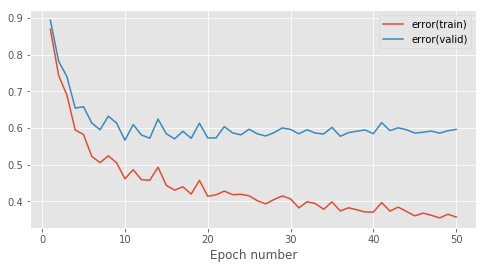

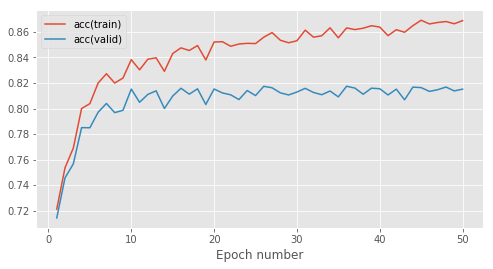

In [7]:
train_data.reset()
test_data.reset()
valid_data.reset()

# Initialise the weights and biases:
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

input_layer = [
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
]
output_layer = [
    func,
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
]
each_hidden_layer = [
    func,
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)
]

# create the MLP:
model = MultipleLayerModel(input_layer + each_hidden_layer * i +
                           output_layer)
print(model, '{} layers'.format(i + 1))

error = CrossEntropySoftmaxError()
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

expt['SGD'] = train_model_and_plot_stats(
    model,
    error,
    learning_rule,
    train_data,
    valid_data,
    test_data,
    num_epochs,
    stats_interval,
    notebook=False)

### Momentum SGD

Repeat the experiment with momentum SGD:

/Users/weiting/MLP2k1718/mlp/errors.py:159: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.sum(targets * np.log(probs), axis=1))
/Users/weiting/MLP2k1718/mlp/errors.py:159: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(np.sum(targets * np.log(probs), axis=1))
Epoch 1: 8.0s to complete
    error(train)=4.99e-01, acc(train)=8.33e-01, error(valid)=6.44e-01, acc(valid)=8.01e-01, error(test)=6.92e-01, acc(test)=7.86e-01
Epoch 2: 7.9s to complete
    error(train)=4.04e-01, acc(train)=8.58e-01, error(valid)=5.75e-01, acc(valid)=8.19e-01, error(test)=6.13e-01, acc(test)=8.10e-01
Epoch 3: 8.0s to complete
    error(train)=3.76e-01, acc(train)=8.67e-01, error(valid)=5.58e-01, acc(valid)=8.25e-01, error(test)=6.07e-01, acc(test)=8.09e-01
Epoch 4: 8.0s to complete
    error(train)=3.51e-01, acc(train)=8.73e-01, error(valid)=5.52e-01, acc(valid)=8.28e-01, error(test)=5.94e-01, acc(test)=8.16e-01
Epoch 5: 8.0s to complete
    error(train)=3.48e-01, a

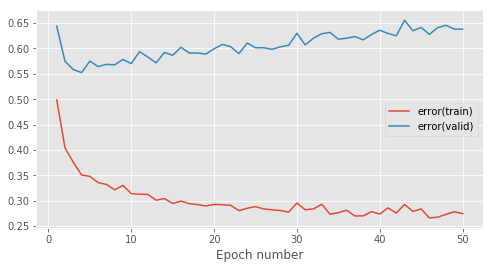

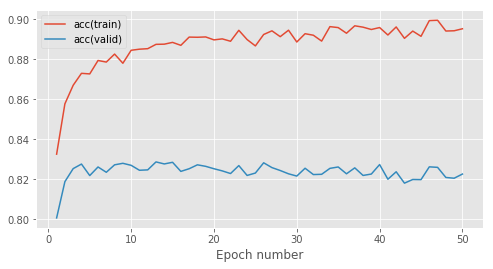

In [18]:
train_data.reset()
test_data.reset()
valid_data.reset()

learning_rule = MomentumLearningRule(learning_rate=0.01, mom_coeff=.9)

expt['MomentumSGD'] = train_model_and_plot_stats(
    model,
    error,
    learning_rule,
    train_data,
    valid_data,
    test_data,
    num_epochs,
    stats_interval,
    notebook=False)

### RMSProp

In [19]:
train_data.reset()
test_data.reset()
valid_data.reset()

learning_rule = RMSPropLearningRule(learning_rate=1e-3, beta=0.9, epsilon=1e-8)

expt['RMSProp'] = train_model_and_plot_stats(
    model,
    error,
    learning_rule,
    train_data,
    valid_data,
    test_data,
    num_epochs,
    stats_interval,
    notebook=False)

Epoch 1: 15.4s to complete
    error(train)=3.63e-01, acc(train)=8.69e-01, error(valid)=6.50e-01, acc(valid)=8.11e-01, error(test)=6.92e-01, acc(test)=8.00e-01
/Users/weiting/MLP2k1718/mlp/errors.py:159: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.sum(targets * np.log(probs), axis=1))
/Users/weiting/MLP2k1718/mlp/errors.py:159: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(np.sum(targets * np.log(probs), axis=1))
Epoch 2: 15.5s to complete
    error(train)=3.61e-01, acc(train)=8.69e-01, error(valid)=6.53e-01, acc(valid)=8.15e-01, error(test)=nan, acc(test)=8.01e-01
Epoch 3: 15.4s to complete
    error(train)=nan, acc(train)=8.69e-01, error(valid)=nan, acc(valid)=8.15e-01, error(test)=nan, acc(test)=8.03e-01
Epoch 4: 15.4s to complete
    error(train)=nan, acc(train)=8.66e-01, error(valid)=nan, acc(valid)=8.10e-01, error(test)=nan, acc(test)=8.02e-01


KeyboardInterrupt: 

### Adam

In [17]:
train_data.reset()
test_data.reset()
valid_data.reset()

learning_rule = AdamLearningRule(learning_rate=1e-3, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8)

expt['adam'] = train_model_and_plot_stats(
    model,
    error,
    learning_rule,
    train_data,
    valid_data,
    test_data,
    num_epochs,
    stats_interval,
    notebook=False)

/Users/weiting/MLP2k1718/mlp/errors.py:159: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.sum(targets * np.log(probs), axis=1))
/Users/weiting/MLP2k1718/mlp/errors.py:159: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(np.sum(targets * np.log(probs), axis=1))


KeyboardInterrupt: 